In [1]:
import datasets
from datasets import load_dataset
from pathlib import Path
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
import evaluate
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = "./datasets/FinQuestions_v2"
token_dir = "./tokenizers/"
model_dir = "./models/"
model_name = "DMetaSoul/Dmeta-embedding-zh-small"  # ~297MB
output_dir="./finetune_small_v2"

finq = load_dataset("parquet", data_dir=data_dir)

# 下面两行代码只需首次运行
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(token_dir+model_name)

tokenizer = AutoTokenizer.from_pretrained(token_dir+model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized = finq.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

id2label = {0: "FALSE", 1: "TRUE"}
label2id = {"FALSE": 0, "TRUE": 1}

# 下面两行代码只需首次运行
model = AutoModelForSequenceClassification.from_pretrained( model_name, num_labels=2, id2label=id2label, label2id=label2id)
model.save_pretrained(model_dir+model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_dir+model_name, 
    num_labels=2, 
    id2label=id2label, 
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DMetaSoul/Dmeta-embedding-zh-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    save_strategy="steps",
    eval_steps=0.02,
    save_steps=0.02,
    logging_steps=0.02,
    save_total_limit=2,
    learning_rate=1e-5,
    per_device_train_batch_size=50, # 显存占用约5217MiB
    per_device_eval_batch_size=50,
    num_train_epochs=6, 
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/192 [00:00<?, ?it/s]

{'loss': 0.691, 'grad_norm': 1.8811014890670776, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.679595947265625, 'eval_accuracy': 0.585, 'eval_runtime': 0.3437, 'eval_samples_per_second': 581.903, 'eval_steps_per_second': 11.638, 'epoch': 0.12}
{'loss': 0.6696, 'grad_norm': 2.066859722137451, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6652376055717468, 'eval_accuracy': 0.66, 'eval_runtime': 0.3379, 'eval_samples_per_second': 591.833, 'eval_steps_per_second': 11.837, 'epoch': 0.25}
{'loss': 0.6687, 'grad_norm': 1.728057861328125, 'learning_rate': 6e-06, 'epoch': 0.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6409053206443787, 'eval_accuracy': 0.7, 'eval_runtime': 0.3368, 'eval_samples_per_second': 593.768, 'eval_steps_per_second': 11.875, 'epoch': 0.38}
{'loss': 0.6234, 'grad_norm': 2.477918863296509, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.6086198687553406, 'eval_accuracy': 0.73, 'eval_runtime': 0.3334, 'eval_samples_per_second': 599.803, 'eval_steps_per_second': 11.996, 'epoch': 0.5}
{'loss': 0.604, 'grad_norm': 1.8023375272750854, 'learning_rate': 1e-05, 'epoch': 0.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.5667508840560913, 'eval_accuracy': 0.745, 'eval_runtime': 0.3379, 'eval_samples_per_second': 591.852, 'eval_steps_per_second': 11.837, 'epoch': 0.62}
{'loss': 0.5641, 'grad_norm': 1.9367485046386719, 'learning_rate': 9.767441860465117e-06, 'epoch': 0.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.516383707523346, 'eval_accuracy': 0.82, 'eval_runtime': 0.3346, 'eval_samples_per_second': 597.675, 'eval_steps_per_second': 11.954, 'epoch': 0.75}
{'loss': 0.5158, 'grad_norm': 1.9844428300857544, 'learning_rate': 9.534883720930234e-06, 'epoch': 0.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.46208304166793823, 'eval_accuracy': 0.92, 'eval_runtime': 0.3362, 'eval_samples_per_second': 594.896, 'eval_steps_per_second': 11.898, 'epoch': 0.88}
{'loss': 0.4441, 'grad_norm': 2.1011428833007812, 'learning_rate': 9.30232558139535e-06, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.40394890308380127, 'eval_accuracy': 0.96, 'eval_runtime': 0.3379, 'eval_samples_per_second': 591.946, 'eval_steps_per_second': 11.839, 'epoch': 1.0}
{'loss': 0.382, 'grad_norm': 2.278578996658325, 'learning_rate': 9.069767441860465e-06, 'epoch': 1.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.34315159916877747, 'eval_accuracy': 0.975, 'eval_runtime': 0.3324, 'eval_samples_per_second': 601.757, 'eval_steps_per_second': 12.035, 'epoch': 1.12}
{'loss': 0.3195, 'grad_norm': 2.2126829624176025, 'learning_rate': 8.837209302325582e-06, 'epoch': 1.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.2820986807346344, 'eval_accuracy': 0.98, 'eval_runtime': 0.3479, 'eval_samples_per_second': 574.913, 'eval_steps_per_second': 11.498, 'epoch': 1.25}
{'loss': 0.2604, 'grad_norm': 2.2708582878112793, 'learning_rate': 8.604651162790698e-06, 'epoch': 1.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.22473125159740448, 'eval_accuracy': 0.985, 'eval_runtime': 0.3362, 'eval_samples_per_second': 594.835, 'eval_steps_per_second': 11.897, 'epoch': 1.38}
{'loss': 0.1944, 'grad_norm': 2.1059961318969727, 'learning_rate': 8.372093023255815e-06, 'epoch': 1.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.1731148511171341, 'eval_accuracy': 0.99, 'eval_runtime': 0.3364, 'eval_samples_per_second': 594.616, 'eval_steps_per_second': 11.892, 'epoch': 1.5}
{'loss': 0.1525, 'grad_norm': 1.6732110977172852, 'learning_rate': 8.139534883720931e-06, 'epoch': 1.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.12891501188278198, 'eval_accuracy': 0.99, 'eval_runtime': 0.3371, 'eval_samples_per_second': 593.375, 'eval_steps_per_second': 11.867, 'epoch': 1.62}
{'loss': 0.1005, 'grad_norm': 1.254931926727295, 'learning_rate': 7.906976744186048e-06, 'epoch': 1.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.09290317445993423, 'eval_accuracy': 0.99, 'eval_runtime': 0.337, 'eval_samples_per_second': 593.553, 'eval_steps_per_second': 11.871, 'epoch': 1.75}
{'loss': 0.0925, 'grad_norm': 0.9019926190376282, 'learning_rate': 7.674418604651164e-06, 'epoch': 1.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.06552976369857788, 'eval_accuracy': 0.99, 'eval_runtime': 0.3398, 'eval_samples_per_second': 588.536, 'eval_steps_per_second': 11.771, 'epoch': 1.88}
{'loss': 0.051, 'grad_norm': 0.7283670902252197, 'learning_rate': 7.44186046511628e-06, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.045936670154333115, 'eval_accuracy': 0.99, 'eval_runtime': 0.3413, 'eval_samples_per_second': 586.005, 'eval_steps_per_second': 11.72, 'epoch': 2.0}
{'loss': 0.0359, 'grad_norm': 0.8804190158843994, 'learning_rate': 7.209302325581395e-06, 'epoch': 2.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.032565440982580185, 'eval_accuracy': 0.995, 'eval_runtime': 0.3337, 'eval_samples_per_second': 599.427, 'eval_steps_per_second': 11.989, 'epoch': 2.12}
{'loss': 0.0279, 'grad_norm': 0.3512308895587921, 'learning_rate': 6.976744186046513e-06, 'epoch': 2.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.025406163185834885, 'eval_accuracy': 0.995, 'eval_runtime': 0.3323, 'eval_samples_per_second': 601.942, 'eval_steps_per_second': 12.039, 'epoch': 2.25}
{'loss': 0.0306, 'grad_norm': 2.141197681427002, 'learning_rate': 6.744186046511628e-06, 'epoch': 2.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.022484904155135155, 'eval_accuracy': 0.99, 'eval_runtime': 0.3434, 'eval_samples_per_second': 582.41, 'eval_steps_per_second': 11.648, 'epoch': 2.38}
{'loss': 0.0107, 'grad_norm': 0.19266383349895477, 'learning_rate': 6.511627906976745e-06, 'epoch': 2.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.021598966792225838, 'eval_accuracy': 0.99, 'eval_runtime': 0.3339, 'eval_samples_per_second': 598.924, 'eval_steps_per_second': 11.978, 'epoch': 2.5}
{'loss': 0.0097, 'grad_norm': 0.17005693912506104, 'learning_rate': 6.279069767441861e-06, 'epoch': 2.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.020732486620545387, 'eval_accuracy': 0.99, 'eval_runtime': 0.3378, 'eval_samples_per_second': 592.127, 'eval_steps_per_second': 11.843, 'epoch': 2.62}
{'loss': 0.0101, 'grad_norm': 0.1547311395406723, 'learning_rate': 6.046511627906977e-06, 'epoch': 2.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.017911270260810852, 'eval_accuracy': 0.99, 'eval_runtime': 0.3388, 'eval_samples_per_second': 590.324, 'eval_steps_per_second': 11.806, 'epoch': 2.75}
{'loss': 0.0073, 'grad_norm': 0.14757901430130005, 'learning_rate': 5.8139534883720935e-06, 'epoch': 2.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.015859099105000496, 'eval_accuracy': 0.99, 'eval_runtime': 0.3406, 'eval_samples_per_second': 587.206, 'eval_steps_per_second': 11.744, 'epoch': 2.88}
{'loss': 0.0087, 'grad_norm': 0.10227556526660919, 'learning_rate': 5.58139534883721e-06, 'epoch': 3.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.015652386471629143, 'eval_accuracy': 0.99, 'eval_runtime': 0.3372, 'eval_samples_per_second': 593.041, 'eval_steps_per_second': 11.861, 'epoch': 3.0}
{'loss': 0.0057, 'grad_norm': 0.11673838645219803, 'learning_rate': 5.348837209302326e-06, 'epoch': 3.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01573019102215767, 'eval_accuracy': 0.99, 'eval_runtime': 0.3367, 'eval_samples_per_second': 594.032, 'eval_steps_per_second': 11.881, 'epoch': 3.12}
{'loss': 0.0048, 'grad_norm': 0.08589881658554077, 'learning_rate': 5.116279069767442e-06, 'epoch': 3.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.015719853341579437, 'eval_accuracy': 0.99, 'eval_runtime': 0.3434, 'eval_samples_per_second': 582.462, 'eval_steps_per_second': 11.649, 'epoch': 3.25}
{'loss': 0.0053, 'grad_norm': 0.27219676971435547, 'learning_rate': 4.883720930232559e-06, 'epoch': 3.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01593710295855999, 'eval_accuracy': 0.99, 'eval_runtime': 0.3352, 'eval_samples_per_second': 596.691, 'eval_steps_per_second': 11.934, 'epoch': 3.38}
{'loss': 0.0042, 'grad_norm': 0.08831091970205307, 'learning_rate': 4.651162790697675e-06, 'epoch': 3.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01627558097243309, 'eval_accuracy': 0.99, 'eval_runtime': 0.3414, 'eval_samples_per_second': 585.783, 'eval_steps_per_second': 11.716, 'epoch': 3.5}
{'loss': 0.0048, 'grad_norm': 0.13188745081424713, 'learning_rate': 4.418604651162791e-06, 'epoch': 3.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01603003777563572, 'eval_accuracy': 0.99, 'eval_runtime': 0.3422, 'eval_samples_per_second': 584.513, 'eval_steps_per_second': 11.69, 'epoch': 3.62}
{'loss': 0.0046, 'grad_norm': 0.13276945054531097, 'learning_rate': 4.186046511627907e-06, 'epoch': 3.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.014704235829412937, 'eval_accuracy': 0.99, 'eval_runtime': 0.3384, 'eval_samples_per_second': 591.048, 'eval_steps_per_second': 11.821, 'epoch': 3.75}
{'loss': 0.0038, 'grad_norm': 0.0852687805891037, 'learning_rate': 3.953488372093024e-06, 'epoch': 3.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01366362813860178, 'eval_accuracy': 0.99, 'eval_runtime': 0.35, 'eval_samples_per_second': 571.498, 'eval_steps_per_second': 11.43, 'epoch': 3.88}
{'loss': 0.0038, 'grad_norm': 0.08858761191368103, 'learning_rate': 3.72093023255814e-06, 'epoch': 4.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.012817276641726494, 'eval_accuracy': 0.99, 'eval_runtime': 0.3425, 'eval_samples_per_second': 583.868, 'eval_steps_per_second': 11.677, 'epoch': 4.0}
{'loss': 0.0034, 'grad_norm': 0.06378491222858429, 'learning_rate': 3.4883720930232564e-06, 'epoch': 4.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.012147814966738224, 'eval_accuracy': 0.99, 'eval_runtime': 0.3441, 'eval_samples_per_second': 581.277, 'eval_steps_per_second': 11.626, 'epoch': 4.12}
{'loss': 0.0033, 'grad_norm': 0.06591153144836426, 'learning_rate': 3.2558139534883724e-06, 'epoch': 4.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.011665292084217072, 'eval_accuracy': 0.99, 'eval_runtime': 0.3426, 'eval_samples_per_second': 583.821, 'eval_steps_per_second': 11.676, 'epoch': 4.25}
{'loss': 0.0048, 'grad_norm': 0.1402503103017807, 'learning_rate': 3.0232558139534885e-06, 'epoch': 4.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01201527751982212, 'eval_accuracy': 0.99, 'eval_runtime': 0.3445, 'eval_samples_per_second': 580.475, 'eval_steps_per_second': 11.61, 'epoch': 4.38}
{'loss': 0.0031, 'grad_norm': 0.059944264590740204, 'learning_rate': 2.790697674418605e-06, 'epoch': 4.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.012505818158388138, 'eval_accuracy': 0.99, 'eval_runtime': 0.3414, 'eval_samples_per_second': 585.863, 'eval_steps_per_second': 11.717, 'epoch': 4.5}
{'loss': 0.0032, 'grad_norm': 0.05830724164843559, 'learning_rate': 2.558139534883721e-06, 'epoch': 4.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.012643206864595413, 'eval_accuracy': 0.99, 'eval_runtime': 0.3383, 'eval_samples_per_second': 591.271, 'eval_steps_per_second': 11.825, 'epoch': 4.62}
{'loss': 0.0032, 'grad_norm': 0.0748254731297493, 'learning_rate': 2.3255813953488376e-06, 'epoch': 4.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.012545422650873661, 'eval_accuracy': 0.99, 'eval_runtime': 0.3391, 'eval_samples_per_second': 589.832, 'eval_steps_per_second': 11.797, 'epoch': 4.75}
{'loss': 0.0029, 'grad_norm': 0.06579551845788956, 'learning_rate': 2.0930232558139536e-06, 'epoch': 4.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.012324976734817028, 'eval_accuracy': 0.99, 'eval_runtime': 0.3376, 'eval_samples_per_second': 592.505, 'eval_steps_per_second': 11.85, 'epoch': 4.88}
{'loss': 0.0028, 'grad_norm': 0.06029514595866203, 'learning_rate': 1.86046511627907e-06, 'epoch': 5.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01218625158071518, 'eval_accuracy': 0.99, 'eval_runtime': 0.3373, 'eval_samples_per_second': 592.891, 'eval_steps_per_second': 11.858, 'epoch': 5.0}
{'loss': 0.0027, 'grad_norm': 0.060297731310129166, 'learning_rate': 1.6279069767441862e-06, 'epoch': 5.12}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.012126610614359379, 'eval_accuracy': 0.99, 'eval_runtime': 0.3402, 'eval_samples_per_second': 587.847, 'eval_steps_per_second': 11.757, 'epoch': 5.12}
{'loss': 0.0028, 'grad_norm': 0.06057797372341156, 'learning_rate': 1.3953488372093025e-06, 'epoch': 5.25}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01205923780798912, 'eval_accuracy': 0.99, 'eval_runtime': 0.3374, 'eval_samples_per_second': 592.764, 'eval_steps_per_second': 11.855, 'epoch': 5.25}
{'loss': 0.0032, 'grad_norm': 0.0661676898598671, 'learning_rate': 1.1627906976744188e-06, 'epoch': 5.38}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01201004721224308, 'eval_accuracy': 0.99, 'eval_runtime': 0.3332, 'eval_samples_per_second': 600.237, 'eval_steps_per_second': 12.005, 'epoch': 5.38}
{'loss': 0.0026, 'grad_norm': 0.05748872458934784, 'learning_rate': 9.30232558139535e-07, 'epoch': 5.5}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.01194709911942482, 'eval_accuracy': 0.99, 'eval_runtime': 0.336, 'eval_samples_per_second': 595.29, 'eval_steps_per_second': 11.906, 'epoch': 5.5}
{'loss': 0.0027, 'grad_norm': 0.06563560664653778, 'learning_rate': 6.976744186046513e-07, 'epoch': 5.62}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.011891257017850876, 'eval_accuracy': 0.99, 'eval_runtime': 0.3515, 'eval_samples_per_second': 569.051, 'eval_steps_per_second': 11.381, 'epoch': 5.62}
{'loss': 0.0025, 'grad_norm': 0.05006970092654228, 'learning_rate': 4.651162790697675e-07, 'epoch': 5.75}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.011846031993627548, 'eval_accuracy': 0.99, 'eval_runtime': 0.3488, 'eval_samples_per_second': 573.388, 'eval_steps_per_second': 11.468, 'epoch': 5.75}
{'loss': 0.0023, 'grad_norm': 0.05112167447805405, 'learning_rate': 2.3255813953488374e-07, 'epoch': 5.88}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.011821911670267582, 'eval_accuracy': 0.99, 'eval_runtime': 0.3399, 'eval_samples_per_second': 588.391, 'eval_steps_per_second': 11.768, 'epoch': 5.88}
{'loss': 0.0026, 'grad_norm': 0.0867215022444725, 'learning_rate': 0.0, 'epoch': 6.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.011811017990112305, 'eval_accuracy': 0.99, 'eval_runtime': 0.335, 'eval_samples_per_second': 597.008, 'eval_steps_per_second': 11.94, 'epoch': 6.0}
{'train_runtime': 109.1139, 'train_samples_per_second': 87.981, 'train_steps_per_second': 1.76, 'train_loss': 0.13665436631223807, 'epoch': 6.0}


TrainOutput(global_step=192, training_loss=0.13665436631223807, metrics={'train_runtime': 109.1139, 'train_samples_per_second': 87.981, 'train_steps_per_second': 1.76, 'total_flos': 282002612595600.0, 'train_loss': 0.13665436631223807, 'epoch': 6.0})

  0%|          | 0/4 [00:00<?, ?it/s]

Confusion Matrix:
[[101   0]
 [  1  98]]


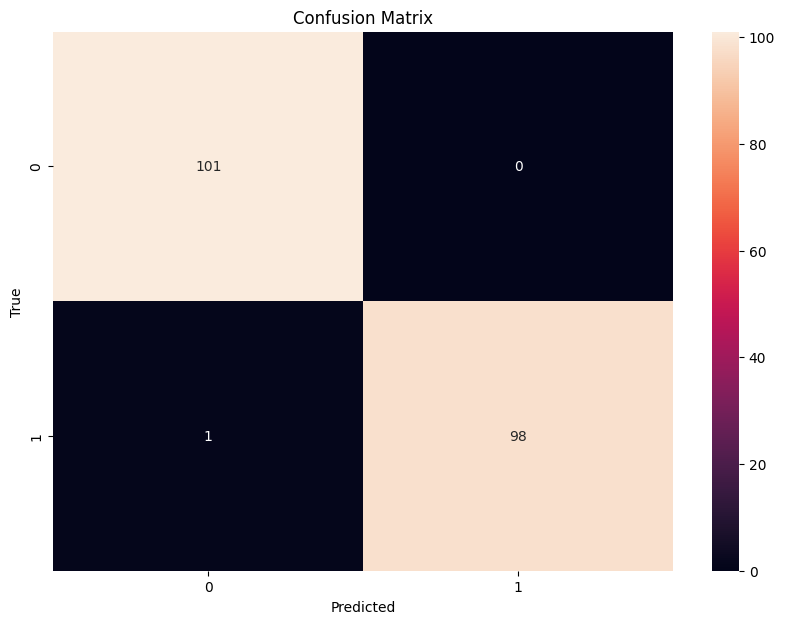

In [3]:
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = tokenized["test"]["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 使用seaborn绘制混淆矩阵的热力图
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [4]:
from sklearn.metrics import confusion_matrix
import pandas as pd
# 加载测试数据
test_data = pd.read_parquet("./datasets/FinQuestions_v2/test.parquet")

# 预测
predictions = trainer.predict(tokenized["test"]).predictions
predictions = np.argmax(predictions, axis=1)
true_labels = test_data["label"]

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 找出预测错误的案例
wrong_predictions = test_data[predictions != true_labels]

# 打印预测错误的案例
for index, row in wrong_predictions.iterrows():
    print(f"True Label: {row['label']}, Predicted Label: {predictions[index]}, Text: {row['text']}")

  0%|          | 0/4 [00:00<?, ?it/s]

Confusion Matrix:
[[101   0]
 [  1  98]]
True Label: 1, Predicted Label: 0, Text: 生态环境建设行业的上游是什么行业？


In [5]:
text = "2024年3月18日基金走势如何？"

# classifier = pipeline("sentiment-analysis", model=output_dir+"/checkpoint-75")
# classifier(text)